# Setup

## Imports

In [63]:
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, roc_auc_score

import gd as gd
import math
from random import randint
from sklearn.ensemble import IsolationForest
import seaborn as sns

## Constants

In [64]:
# Generalized Deduplication
DEVIATION_BITS = 6

# Isolation Forest
rng = np.random.RandomState(42)

# Performance
time_no_iterations = 1
time_no_outliers_removed = 0

# Load Data

## Generate data

In [65]:
from scipy.io import arff
from sklearn.model_selection import train_test_split

data = arff.loadarff('./data/PenDigits/PenDigits_withoutdupl_norm_v10.arff')
df = pd.DataFrame(data[0])
df['outlier'].mask(df['outlier'] == b'no', 1, inplace=True)
df['outlier'].mask(df['outlier'] == b'yes', -1, inplace=True)
y = df.pop('outlier').values.astype(int)
id = df.pop('id')
df = df.astype(int)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rng)

## Perform Generalized Deduplication

In [66]:
vectorized_func = np.vectorize(gd.compress_int)

X_train_bases = vectorized_func(X_train, deviation_bits=DEVIATION_BITS, output="integer")
X_test_bases = vectorized_func(X_test, deviation_bits=DEVIATION_BITS, output="integer")

# Model Training

## Setup

In [67]:
gd_df_results = pd.DataFrame()
gd_ext_df_results = pd.DataFrame()
org_df_results = pd.DataFrame()
performance = pd.DataFrame(columns=['name', 'deviation_bits', 'test_accuracy_score', 'test_f1_score', 'test_recall_score', 'test_precision_score',
  'test_roc_auc_score', 'training_time', 'prediction_time'])


def create_performance_object(name, deviation_bits, y_pred_train, y_pred_test, training_time, prediction_time, test_accuracy_score, test_f1_score, test_recall_score, test_precision_score, test_roc_auc_score):
    return {
    'name': name,
    'deviation_bits': deviation_bits,
    #'train_accuracy_score': accuracy_score(y_train, y_pred_train),
    'test_accuracy_score': test_accuracy_score,

    #'train_f1_score': f1_score(y_train, y_pred_train),
    'test_f1_score': test_f1_score,
    #'train_recall_score': recall_score(y_train, y_pred_train),
    'test_recall_score': test_recall_score,
    'test_precision_score': test_precision_score,
    #'train_roc_auc_score': roc_auc_score(y_train, y_pred_train),
    'test_roc_auc_score': test_roc_auc_score,
    'training_time': training_time,
    'prediction_time': prediction_time,
    }

## Isolation Forest - Bases

In [68]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []
precs = []
for i in range(0, time_no_iterations):
    gd_clf = IsolationForest()
    start_time = time.time()
    gd_clf.fit(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_test = gd_clf.predict(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))
    precs.append(precision_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)
precs = pd.DataFrame(precs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)

performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)

/tmp/ipykernel_81236/419497392.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)


## Isolation Forest - Bases - Extended

In [69]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []
precs = []

for i in range(0, time_no_iterations):
    gd_ext_clf = IsolationForest()
    start_time = time.time()
    gd_ext_clf.fit_extended(X_train_bases)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_test = gd_ext_clf.predict_extended(X_test_bases)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))
    precs.append(precision_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)
precs = pd.DataFrame(precs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)



performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)

/home/mlrosenquist/repos/scikit-learn/sklearn/ensemble/_iforest.py:419: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_unique_ = self.df_unique_.append(pd.DataFrame(unique), ignore_index=True)
/tmp/ipykernel_81236/3617976735.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Bases - extended', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)


## Isolation Forest Original Data

In [70]:
training_times = []
prediction_times = []
accuracies = []
f1s = []
recs = []
rocs = []
precs = []

for i in range(0, time_no_iterations):
    org_clf = IsolationForest()
    start_time = time.time()
    org_clf.fit(X_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)

    start_time = time.time()
    y_pred_test = org_clf.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    prediction_times.append(prediction_time)

    accuracies.append(accuracy_score(y_test, y_pred_test))
    f1s.append(f1_score(y_test, y_pred_test))
    recs.append(recall_score(y_test, y_pred_test))
    rocs.append(roc_auc_score(y_test, y_pred_test))
    precs.append(precision_score(y_test, y_pred_test))

training_times = pd.DataFrame(training_times)
prediction_times = pd.DataFrame(prediction_times)
accuracies = pd.DataFrame(accuracies)
f1s = pd.DataFrame(f1s)
recs = pd.DataFrame(recs)
rocs = pd.DataFrame(rocs)
precs = pd.DataFrame(precs)

training_times = training_times.drop(training_times.nsmallest(time_no_outliers_removed, 0).index).drop(training_times.nlargest(time_no_outliers_removed, 0).index)
prediction_times = prediction_times.drop(prediction_times.nsmallest(time_no_outliers_removed, 0).index).drop(prediction_times.nlargest(time_no_outliers_removed, 0).index)

performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)

/tmp/ipykernel_81236/3376321955.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance = performance.append(create_performance_object('Isolation Forest Original', DEVIATION_BITS, None, y_pred_test, training_times[0].mean(), prediction_times[0].mean(), accuracies[0].mean(), f1s[0].mean(), recs[0].mean(), precs[0].mean(), rocs[0].mean()), ignore_index=True)


# Performance evaluation

## Overview

In [71]:

test_unique, test_idx, test_counts = np.unique([tuple(row) for row in X_test_bases], axis=0, return_index=True, return_counts=True)
train_unique, train_idx, train_counts = np.unique([tuple(row) for row in X_train_bases], axis=0, return_index=True, return_counts=True)

print(f"Amount Train Uniques: {len(train_unique)}" )
print(f"Amount Test Samples: {len(X_test_bases)}")
print(f"Amount Test Uniques: {len(test_unique)}" )

uncompressed_bits = 8*16*len(X_test_bases)
lossy_bits = (8-DEVIATION_BITS)*16*len(test_unique)
print(f"Uncompressed bits: {8} * {16} * {len(X_test_bases)} =  {uncompressed_bits}")
print(f"Lossy compression bits: {8-DEVIATION_BITS} * {16} * {len(test_unique)} =  {lossy_bits} ")
print(f"Lossy Compression rate: uncompressed bits /lossy bits = {lossy_bits/uncompressed_bits}")
count_table_bytes = (((16) * (8-DEVIATION_BITS) * len(train_unique)) + (8 * len(train_unique)))  / 8
print(f"Unique count table size: {count_table_bytes}")

Amount Train Uniques: 849
Amount Test Samples: 1974
Amount Test Uniques: 441
Uncompressed bits: 8 * 16 * 1974 =  252672
Lossy compression bits: 2 * 16 * 441 =  14112 
Lossy Compression rate: uncompressed bits /lossy bits = 0.05585106382978723
Unique count table size: 4245.0


In [72]:
from pathlib import Path
filepath = Path(f'./results/pendigits-{DEVIATION_BITS}dev.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)

performance.to_csv(filepath)
performance

,name,deviation_bits,test_accuracy_score,test_f1_score,test_recall_score,test_precision_score,test_roc_auc_score,training_time,prediction_time
0,Isolation Forest Bases,6,0.402229,0.572464,0.401015,1.0,0.700508,0.106674,0.061259
1,Isolation Forest Bases - extended,6,0.802432,0.890203,0.802538,0.999368,0.776269,0.145038,0.141757
2,Isolation Forest Original,6,0.546099,0.70565,0.545178,1.0,0.772589,0.098418,0.059484


## Confusion Matrices

/tmp/ipykernel_81236/1162717073.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


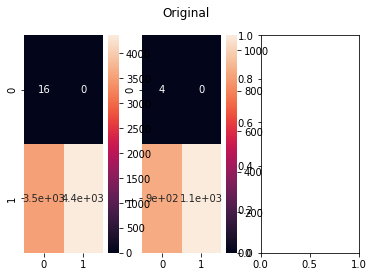

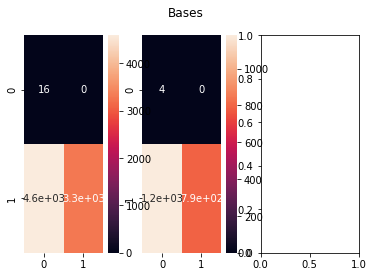

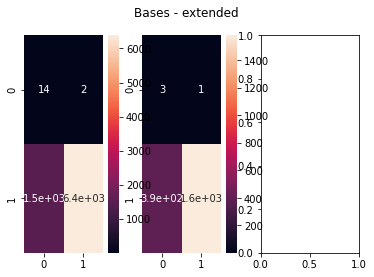

In [73]:

y_train_clipped = y_train.clip(min=0)
y_test_clipped = y_test.clip(min=0)

# Original
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Original")

y_train_pred =  org_clf.predict(X_train).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  org_clf.predict(X_test).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases")

y_train_pred =  gd_clf.predict(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_clf.predict(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

# GD Extended
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Bases - extended")
y_train_pred =  gd_ext_clf.predict_extended(X_train_bases).clip(min=0)
cf_matrix = confusion_matrix(y_train_clipped, y_train_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax1)

y_test_pred =  gd_ext_clf.predict_extended(X_test_bases).clip(min=0)
cf_matrix = confusion_matrix(y_test_clipped, y_test_pred)
sns.heatmap(cf_matrix, annot=True, ax=ax2)

fig.show()

# Data Visualization

## Bases - density

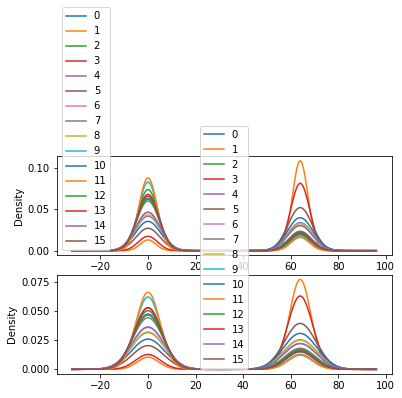

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1)
pd.DataFrame(X_train_bases).plot.density(ax=axes[0])
pd.DataFrame(X_test_bases).plot.density(ax=axes[1])
plt.show()